In [1]:
# Install the necessary package (run this separately if not already installed)
# !pip install econml

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, ttest_ind, f_oneway

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from econml.grf import RegressionForest, CausalForest
from econml.dml import CausalForestDML
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLassoCV

# Descriptives

In [2]:
#load the data
data = pd.read_csv("processed_esti.csv")

#Display first few rows
display(data.head())

,y,w,gender_female,gender_male,gender_transgender,ethnicgrp_asian,ethnicgrp_black,ethnicgrp_mixed_multiple,ethnicgrp_other,ethnicgrp_white,partners1,postlaunch,msm,age,imd_decile
0,1,1,0,1,0,0,0,1,0,0,0,1,0,27,5
1,0,0,0,1,0,0,0,0,0,1,0,0,0,19,6
2,0,1,0,1,0,0,1,0,0,0,0,1,0,26,4
3,0,0,1,0,0,0,0,0,0,1,1,0,0,20,2
4,1,1,1,0,0,1,0,0,0,0,0,1,0,24,3


This study focuses on evaluating the effectiveness of internet-accessed STI testing (e-STI testing) compared to traditional face-to-face services. The e-STI testing service, known as SH:24, offers postal self-sampling test kits for chlamydia, gonorrhoea, HIV, and syphilis, with results communicated via text message or telephone and supported by web-based safer sex health information. This randomized controlled trial aims to assess the impact of SH:24 on the uptake of STI testing, diagnosis, and treatment when delivered alongside usual care. The findings from this study could inform strategies to improve STI testing and treatment services and address public health concerns associated with STIs.

In [3]:
# Define the variables to include in the table
variables = [
    'y', 'w', 'gender_female', 'gender_male', 'gender_transgender', 
    'ethnicgrp_asian', 'ethnicgrp_black', 'ethnicgrp_mixed_multiple', 
    'ethnicgrp_other', 'ethnicgrp_white', 'partners1', 'postlaunch', 
    'age', 'imd_decile'
]

# Split the data into control and treatment groups
control_group = data[data['w'] == 0]
treatment_group = data[data['w'] == 1]

# Function to calculate mean, std, and diff
def calculate_stats(variable):
    control_mean = control_group[variable].mean()
    control_std = control_group[variable].std()
    treatment_mean = treatment_group[variable].mean()
    treatment_std = treatment_group[variable].std()
    diff = sm.OLS(data[variable], sm.add_constant(data['w'])).fit().params[1]
    return control_mean, control_std, treatment_mean, treatment_std, diff

# Create the balance table
balance_table = pd.DataFrame(columns=['Control mean', 'Control sd', 'Treatment mean', 'Treatment sd', 'Diff'])

for var in variables:
    control_mean, control_std, treatment_mean, treatment_std, diff = calculate_stats(var)
    balance_table.loc[var] = [control_mean, control_std, treatment_mean, treatment_std, diff]

# Display the balance table
balance_table

,Control mean,Control sd,Treatment mean,Treatment sd,Diff
y,0.211491,0.408616,0.476656,0.499726,0.265164
w,0.000000,0.000000,1.000000,0.000000,1.000000
gender_female,0.580685,0.493749,0.587405,0.492569,0.006720
gender_male,0.418093,0.493547,0.409338,0.491979,-0.008755
gender_transgender,0.001222,0.034964,0.003257,0.057011,0.002035
ethnicgrp_asian,0.055012,0.228144,0.071661,0.258066,0.016649
ethnicgrp_black,0.092910,0.290483,0.080347,0.271978,-0.012562
ethnicgrp_mixed_multiple,0.092910,0.290483,0.084691,0.278572,-0.008219
ethnicgrp_other,0.017115,0.129779,0.009772,0.098423,-0.007343
ethnicgrp_white,0.742054,0.437772,0.753529,0.431190,0.011475


We can observe a similar composition of the treatment and control groups in all variables.

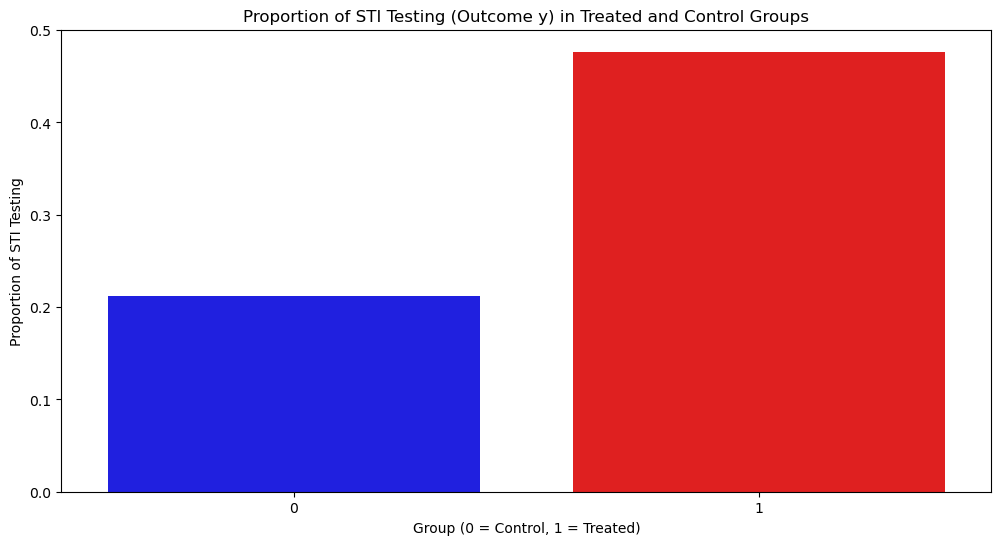

In [4]:
# Proportion of STI Testing (Outcome y) in Treated and Control Groups
plt.figure(figsize=(12, 6))
sns.barplot(x='w', y='y', data=data, palette=['blue', 'red'], errorbar=None)
plt.title('Proportion of STI Testing (Outcome y) in Treated and Control Groups')
plt.xlabel('Group (0 = Control, 1 = Treated)')
plt.ylabel('Proportion of STI Testing')
plt.show()

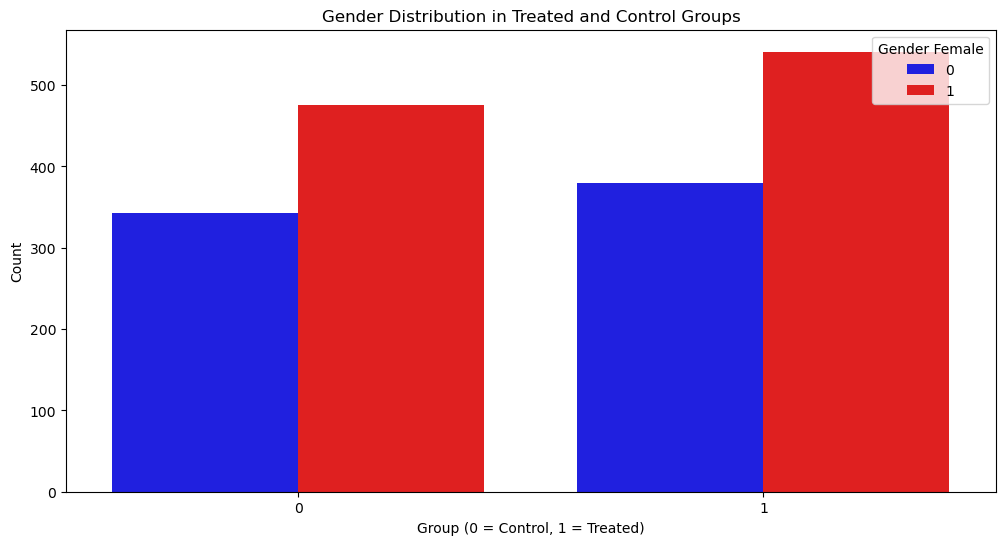

In [5]:
# Gender Distribution in Treated and Control Groups
plt.figure(figsize=(12, 6))
sns.countplot(x='w', hue='gender_female', palette=['blue', 'red'], data=data)
plt.title('Gender Distribution in Treated and Control Groups')
plt.xlabel('Group (0 = Control, 1 = Treated)')
plt.ylabel('Count')
plt.legend(title='Gender Female', loc='upper right')
plt.show()

In [6]:
# Setting up the visualisation style
sns.set(style="whitegrid")

# Define a function to plot histograms for each group separately
def plot_separate_histograms(variable, treated, control):
    plt.figure(figsize=(14, 6))
    
    # Plot for Treated group
    plt.subplot(1, 2, 1)
    sns.histplot(treated[variable], kde=False, color='blue', bins=20, alpha=0.6)
    plt.title(f'Treated Group - Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    
    # Plot for Control group
    plt.subplot(1, 2, 2)
    sns.histplot(control[variable], kde=False, color='red', bins=20, alpha=0.6)
    plt.title(f'Control Group - Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

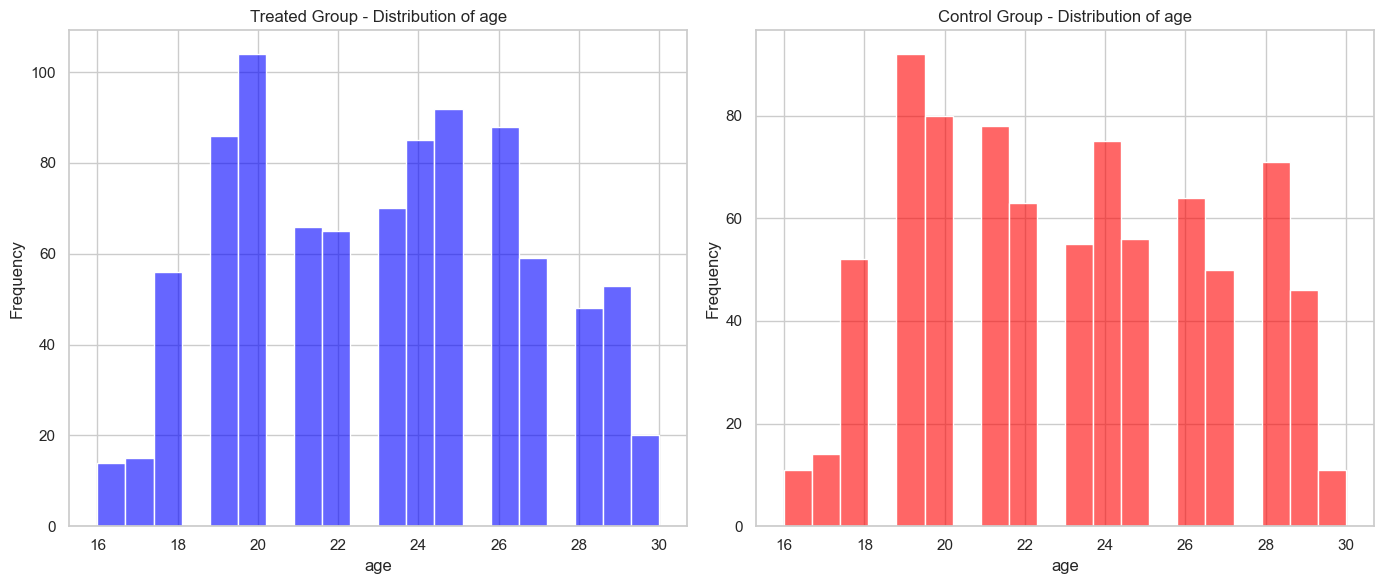

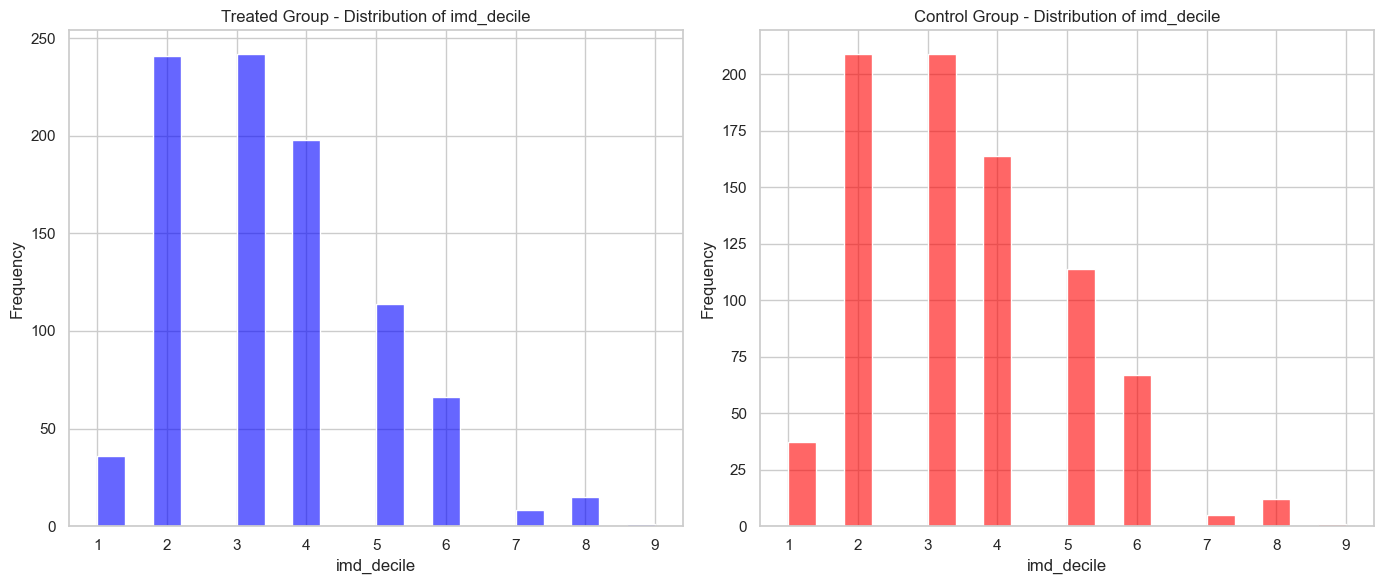

In [7]:
# Numeric variables: 'age', 'imd_decile'
plot_separate_histograms('age', treatment_group, control_group)
plot_separate_histograms('imd_decile', treatment_group, control_group)

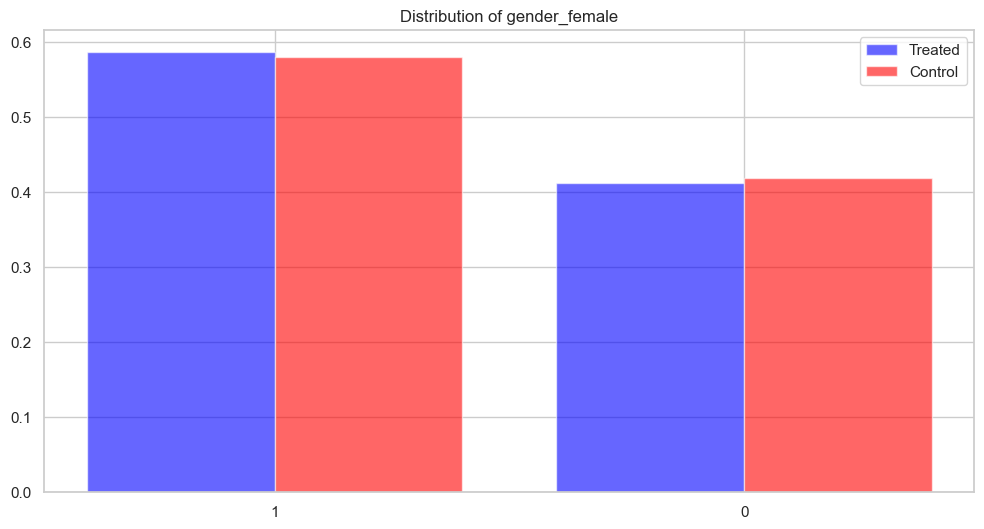

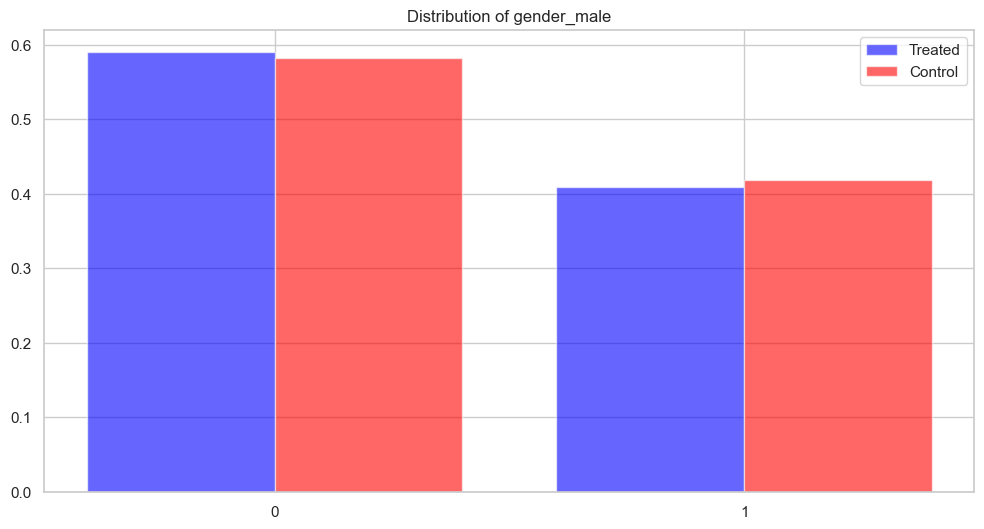

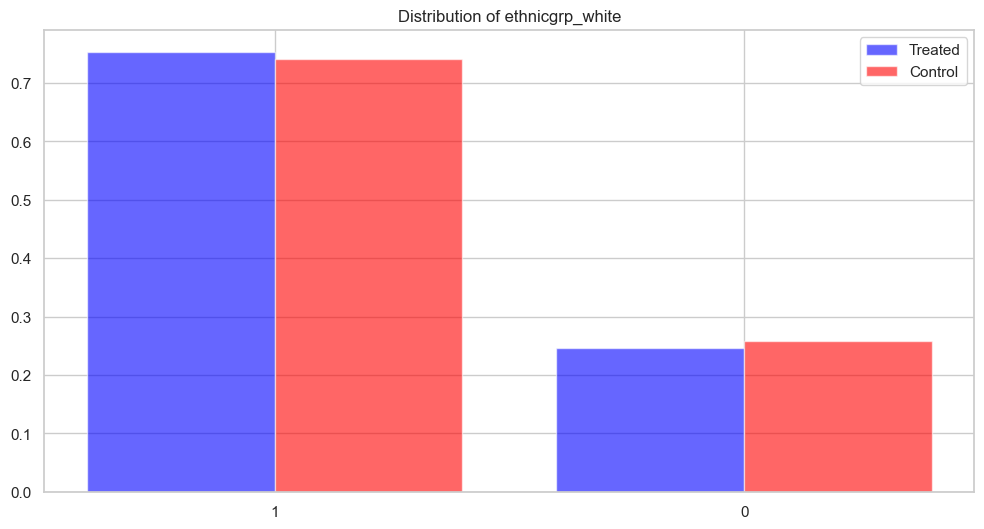

In [8]:
# Define a function to plot histograms and bar plots
def plot_distribution(variable, data, treated, control, kind='hist'):
    plt.figure(figsize=(12, 6))
    if kind == 'hist':
        sns.histplot(treated[variable], kde=False, color='blue', label='Treated', stat='density', bins=20, alpha=0.6)
        sns.histplot(control[variable], kde=False, color='red', label='Control', stat='density', bins=20, alpha=0.6)
    elif kind == 'bar':
        treated_counts = treated[variable].value_counts(normalize=True)
        control_counts = control[variable].value_counts(normalize=True)
        index = treated_counts.index.union(control_counts.index)
        treated_counts = treated_counts.reindex(index, fill_value=0)
        control_counts = control_counts.reindex(index, fill_value=0)
        bar_width = 0.4
        index = range(len(index))
        plt.bar(index, treated_counts, width=bar_width, color='blue', label='Treated', alpha=0.6)
        plt.bar([i + bar_width for i in index], control_counts, width=bar_width, color='red', label='Control', alpha=0.6)
        plt.xticks([i + bar_width / 2 for i in index], treated_counts.index)
    plt.title(f'Distribution of {variable}')
    plt.legend()
    plt.show()

# Categorical variables: 'gender_female', 'gender_male', 'ethnicgrp_white'
plot_distribution('gender_female', data, treatment_group, control_group, kind='bar')
plot_distribution('gender_male', data, treatment_group, control_group, kind='bar')
plot_distribution('ethnicgrp_white', data, treatment_group, control_group, kind='bar')

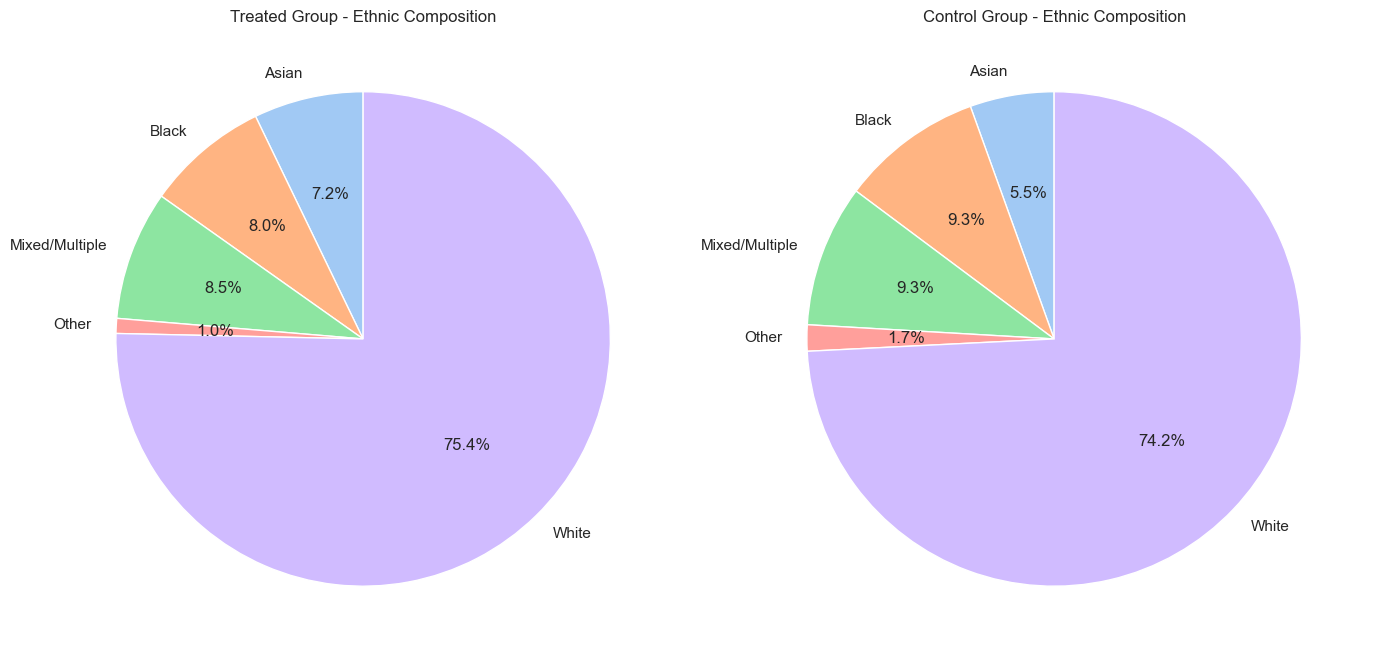

In [9]:
# Define a function to plot pie charts for ethnic group composition with labels
def plot_ethnic_group_piecharts(treated, control):
    # Summarize ethnic group counts for treated group
    treated_ethnic_counts = treated.filter(like='ethnicgrp_').sum()
    
    # Summarize ethnic group counts for control group
    control_ethnic_counts = control.filter(like='ethnicgrp_').sum()
    
    # Define labels for the ethnic groups
    labels = ['Asian', 'Black', 'Mixed/Multiple', 'Other', 'White']
    
    # Pie chart for treated group
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1, 2, 1)
    plt.pie(treated_ethnic_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title('Treated Group - Ethnic Composition')

    # Pie chart for control group
    plt.subplot(1, 2, 2)
    plt.pie(control_ethnic_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title('Control Group - Ethnic Composition')
    
    plt.tight_layout()
    plt.show()

# Plot pie charts for ethnic group composition
plot_ethnic_group_piecharts(treatment_group, control_group)

# Linear regression analysis

In [10]:
# Define the dependent variable and the treatment variable
Y = data['y']
T = data['w']

# Model 1: Y ~ T
X1 = sm.add_constant(T)
model1 = sm.OLS(Y, X1).fit()

# Print model 1 summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     144.5
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           4.96e-32
Time:                        18:05:08   Log-Likelihood:                -1112.9
No. Observations:                1739   AIC:                             2230.
Df Residuals:                    1737   BIC:                             2241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2115      0.016     13.174      0.0

In [11]:
# Model 2: Y ~ T + X (where X are selected covariates, e.g., 'age' and 'gender_female')
X2 = data[['w', 'age', 'gender_female']]
X2 = sm.add_constant(X2)
model2 = sm.OLS(Y, X2).fit()

# Print model 2 summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     62.61
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           1.96e-38
Time:                        18:05:08   Log-Likelihood:                -1093.0
No. Observations:                1739   AIC:                             2194.
Df Residuals:                    1735   BIC:                             2216.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2235      0.075     -2.990

In [12]:
# Double Lasso Method
# Prepare data for Lasso regression
features = data.drop(columns=['y'])
target = data['y']

# Perform LassoCV to select important features
lasso = LassoCV(cv=5, random_state=0).fit(features, target)

# Select features based on LassoCV
selected_features = features.columns[(lasso.coef_ != 0)]

# Ensure that the treatment variable 'w' is included in the selected features
if 'w' not in selected_features:
    selected_features = ['w'] + list(selected_features)

# Model 3: Y ~ T + selected features from Lasso
X3 = data[selected_features]
X3 = sm.add_constant(X3)
model3 = sm.OLS(Y, X3).fit()

# Print model 3 summary
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     31.49
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           2.60e-41
Time:                        18:05:08   Log-Likelihood:                -1078.1
No. Observations:                1739   AIC:                             2172.
Df Residuals:                    1731   BIC:                             2216.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1007      0.079     

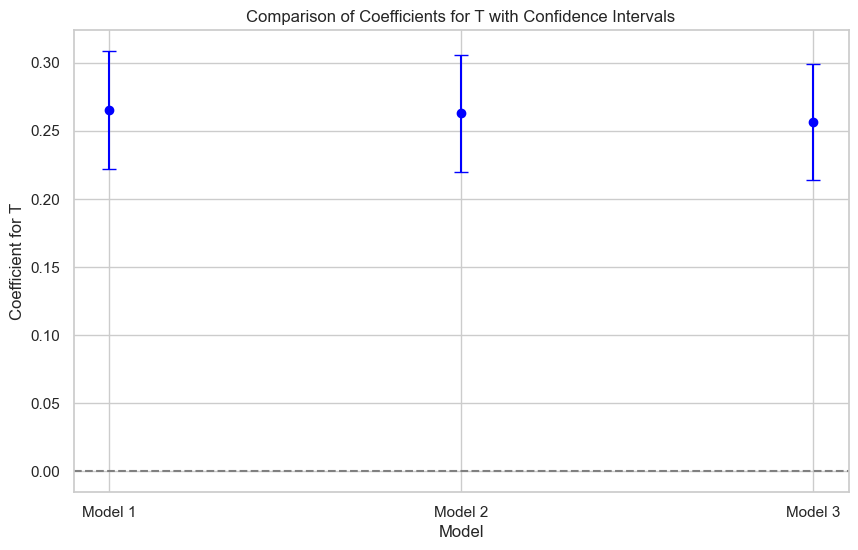

In [13]:
# Extract coefficients and confidence intervals for T from each model
coeffs = {
    'Model 1': model1.params['w'],
    'Model 2': model2.params['w'],
    'Model 3': model3.params['w']
}

conf_intervals = {
    'Model 1': model1.conf_int().loc['w'],
    'Model 2': model2.conf_int().loc['w'],
    'Model 3': model3.conf_int().loc['w']
}

# Plot the coefficients with confidence intervals
plt.figure(figsize=(10, 6))
models = list(coeffs.keys())
estimates = list(coeffs.values())
ci_lower = [conf_intervals[model][0] for model in models]
ci_upper = [conf_intervals[model][1] for model in models]

plt.errorbar(models, estimates, yerr=[estimates[i] - ci_lower[i] for i in range(len(models))], fmt='o', capsize=5, color='blue')
plt.axhline(y=0, color='grey', linestyle='--')
plt.title('Comparison of Coefficients for T with Confidence Intervals')
plt.xlabel('Model')
plt.ylabel('Coefficient for T')
plt.grid(True)
plt.show()

We obtained similar estimates from the three models

# Non-Linear Methods DML

In [14]:
#Hdmpy
import sys
sys.path.insert(0, r"C:\Users\Franc\Python_ML\hdmpy")
import hdmpy

In [15]:
# Define the outcome variable and the treatment variable
Y = data['y']
W = data['w']
X = data.drop(columns=['y', 'w'])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.2, random_state=42)

In [16]:
# Function to run DML
def dml_lasso(X_train, X_test, Y_train, Y_test, T_train, T_test):
    # Step 1: Learn Y and T using Lasso
    lasso_y = LassoCV(cv=5).fit(X_train, Y_train)
    lasso_t = LassoCV(cv=5).fit(X_train, T_train)
    
    # Step 2: Get residuals
    Y_residuals = Y_test - lasso_y.predict(X_test)
    T_residuals = T_test - lasso_t.predict(X_test)
    
    # Step 3: Run OLS on residuals
    ols_model = sm.OLS(Y_residuals, sm.add_constant(T_residuals)).fit()
    return ols_model

# Run DML with Lasso
lasso_model = dml_lasso(X_train, X_test, Y_train, Y_test, T_train, T_test)
print("Lasso DML Results")
print(lasso_model.summary())

Lasso DML Results
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     27.24
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           3.10e-07
Time:                        18:05:10   Log-Likelihood:                -226.67
No. Observations:                 348   AIC:                             457.3
Df Residuals:                     346   BIC:                             465.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0562      0.025  

In [17]:
def dml_tree(X_train, X_test, Y_train, Y_test, T_train, T_test):
    # Step 1: Learn Y and T using Decision Trees
    tree_y = DecisionTreeRegressor().fit(X_train, Y_train)
    tree_t = DecisionTreeRegressor().fit(X_train, T_train)
    
    # Step 2: Get residuals
    Y_residuals = Y_test - tree_y.predict(X_test)
    T_residuals = T_test - tree_t.predict(X_test)
    
    # Step 3: Run OLS on residuals
    ols_model = sm.OLS(Y_residuals, sm.add_constant(T_residuals)).fit()
    return ols_model

# Run DML with Regression Trees
tree_model = dml_tree(X_train, X_test, Y_train, Y_test, T_train, T_test)
print("\nRegression Trees DML Results")
print(tree_model.summary())


Regression Trees DML Results
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     20.37
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           8.78e-06
Time:                        18:05:10   Log-Likelihood:                -289.72
No. Observations:                 348   AIC:                             583.4
Df Residuals:                     346   BIC:                             591.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0587 

In [18]:
def dml_boosting(X_train, X_test, Y_train, Y_test, T_train, T_test):
    # Step 1: Learn Y and T using Boosting Trees
    boost_y = GradientBoostingRegressor().fit(X_train, Y_train)
    boost_t = GradientBoostingRegressor().fit(X_train, T_train)
    
    # Step 2: Get residuals
    Y_residuals = Y_test - boost_y.predict(X_test)
    T_residuals = T_test - boost_t.predict(X_test)
    
    # Step 3: Run OLS on residuals
    ols_model = sm.OLS(Y_residuals, sm.add_constant(T_residuals)).fit()
    return ols_model

# Run DML with Boosting Trees
boosting_model = dml_boosting(X_train, X_test, Y_train, Y_test, T_train, T_test)
print("\nBoosting Trees DML Results")
print(boosting_model.summary())


Boosting Trees DML Results
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     31.74
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           3.66e-08
Time:                        18:05:11   Log-Likelihood:                -232.44
No. Observations:                 348   AIC:                             468.9
Df Residuals:                     346   BIC:                             476.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0555   

In [19]:
# Function to run DML
def dml_model(X_train, X_test, Y_train, Y_test, T_train, T_test, model_y, model_t):
    # Step 1: Learn Y and T using specified models
    model_y.fit(X_train, Y_train)
    model_t.fit(X_train, T_train)

    # Step 2: Get residuals
    Y_residuals = Y_test - model_y.predict(X_test)
    T_residuals = T_test - model_t.predict(X_test)

    # Step 3: Run OLS on residuals
    ols_model = sm.OLS(Y_residuals, sm.add_constant(T_residuals)).fit()
    return ols_model

# Create and fit Regression Forest models
model_y = RandomForestRegressor()
model_t = RandomForestRegressor()

# Call the DML function
forest_model = dml_model(X_train, X_test, Y_train, Y_test, T_train, T_test, model_y, model_t)

print("\nRegression forest DML Results")
print(forest_model.summary())


Regression forest DML Results
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     32.54
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           2.51e-08
Time:                        18:05:13   Log-Likelihood:                -240.69
No. Observations:                 348   AIC:                             485.4
Df Residuals:                     346   BIC:                             493.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0552

               Model  Coefficient  Standard Error   t-value       p-value
0              Lasso     0.261764        0.050150  5.219602  3.098732e-07
1      Decision Tree     0.200849        0.046429  4.325934  1.989870e-05
2      Boosting Tree     0.275253        0.048719  5.649781  3.358347e-08
3  Regression Forest     0.245206        0.044732  5.481712  8.133786e-08


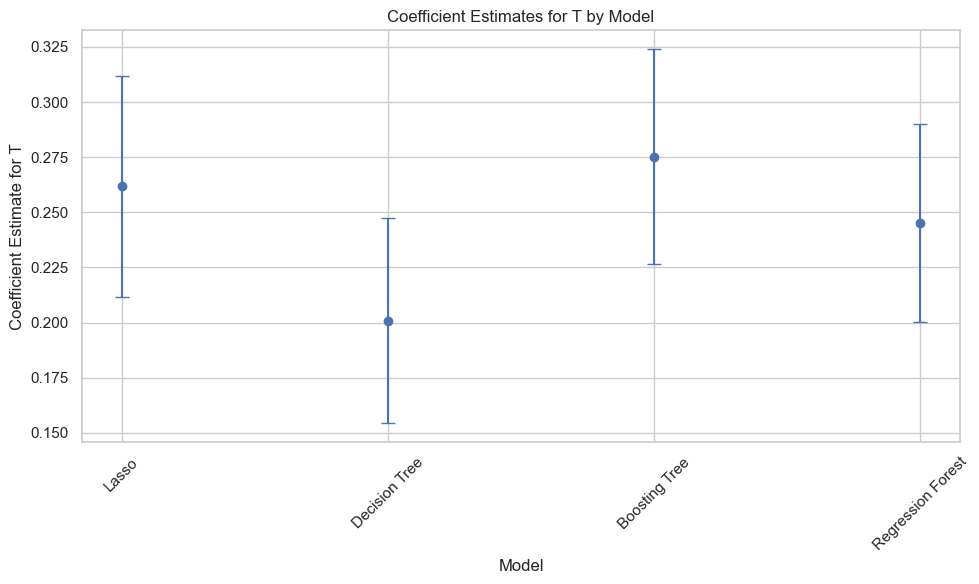

In [21]:
# Define models
models = {
    'Lasso': (LassoCV(cv=5), LassoCV(cv=5)),
    'Decision Tree': (DecisionTreeRegressor(), DecisionTreeRegressor()),
    'Boosting Tree': (GradientBoostingRegressor(), GradientBoostingRegressor()),
    'Regression Forest': (RandomForestRegressor(), RandomForestRegressor())
}

# Run DML for each model and store results
results = {}

for name, (model_y, model_t) in models.items():
    results[name] = dml_model(X_train, X_test, Y_train, Y_test, T_train, T_test, model_y, model_t)

# Create a table with all results
summary_data = []

for name, result in results.items():
    coeff = result.params[1]  # Assuming result has params attribute
    std_err = result.bse[1]   # Assuming result has bse attribute
    t_value = result.tvalues[1]  # Assuming result has tvalues attribute
    p_value = result.pvalues[1]  # Assuming result has pvalues attribute
    
    summary_data.append({
        'Model': name,
        'Coefficient': coeff,
        'Standard Error': std_err,
        't-value': t_value,
        'p-value': p_value
    })

summary_table = pd.DataFrame(summary_data)

# Print summary table
print(summary_table)

# Plot the coefficient estimates
plt.figure(figsize=(10, 6))
plt.errorbar(summary_table['Model'], summary_table['Coefficient'], yerr=summary_table['Standard Error'], fmt='o', capsize=5)
plt.xlabel('Model')
plt.ylabel('Coefficient Estimate for T')
plt.title('Coefficient Estimates for T by Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Recommendation: Lasso Method for DML

1. **Interpretability**: Lasso produces sparse models by forcing some coefficients to be exactly zero, aiding in variable selection and model interpretability.

2. **Variable Selection**: Lasso's ability to shrink coefficients to zero effectively performs variable selection, which can improve model generalization and reduce overfitting.

3. **Regularization**: Lasso's regularization term helps prevent overfitting by penalizing large coefficients, leading to a more robust model, especially with correlated variables.

4. **Performance**: While decision trees, boosting trees, and random forests can be powerful techniques, they might not be as suitable for DML due to complexity and overfitting risks. Lasso is simpler and more interpretable, making it advantageous for DML.

In conclusion, the Lasso method offers a balance between model complexity, interpretability, and performance, making it a suitable choice for your DML procedure.